# Analysis of 2019 Sales

## Data Wrangling & Cleansing

### Setup

In [68]:
# import numpy as np
import pandas as pd
# import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
%reload_ext autoreload
%autoreload 2

### Collate source data

In [69]:
# import os

# df = pd.DataFrame()

# for file in os.listdir('./sales_data'):
#     month = pd.read_csv(f'./sales_data/{ file }', skip_blank_lines=True)
#     df = pd.concat([df, month], ignore_index=True, copy=False)
#     print(f'{file} { month.shape } => { df.shape }')

# df.tail()

### Remove superfluous header rows (interleaved in the data)

In [70]:
# df[df['Order ID'] == 'Order ID'].describe()

Attempting to drop headers via `read_csv()` above added columns. And as
there's `355` header rows within the data, I'm removing altogether here

In [71]:
# # Drop header rows
# df = df[df['Order ID'] != 'Order ID']

# df[df['Order ID'] == 'Order ID'].describe()

### Remove superfluous NaN rows

In [72]:
# df[df.isna().any(axis=1)].info()
# df[df.isna().any(axis=1)].tail()

`545` rows containing `NaN` (or equivalent) in `any` column

In [73]:
# # Drop NaN rows
# df = df[~df.isna().any(axis=1)]

# df[df.isna().any(axis=1)].info()

### Persist combined dataframe

In [74]:
# df.to_csv('2019-sales.cleaned.csv', index=False)

### Reload dataframe `df` from combined file

... with the added benefit that Pandas correctly identifies most column data types

In [75]:
df = pd.read_csv('2019-sales.cleaned.csv')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 185950 entries, 0 to 185949
Data columns (total 6 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Order ID          185950 non-null  int64  
 1   Product           185950 non-null  object 
 2   Quantity Ordered  185950 non-null  int64  
 3   Price Each        185950 non-null  float64
 4   Order Date        185950 non-null  object 
 5   Purchase Address  185950 non-null  object 
dtypes: float64(1), int64(2), object(3)
memory usage: 8.5+ MB


### Order Date => `datetime`

In [76]:
df['Order Date']

0         04/19/19 08:46
1         04/07/19 22:30
2         04/12/19 14:38
3         04/12/19 14:38
4         04/30/19 09:27
               ...      
185945    09/17/19 20:56
185946    09/01/19 16:00
185947    09/23/19 07:39
185948    09/19/19 17:30
185949    09/30/19 00:18
Name: Order Date, Length: 185950, dtype: object

In [77]:
df['Order Date'] = pd.to_datetime(df['Order Date'], format='%m/%d/%y %H:%M')
df.sort_values(by='Order Date', inplace=True)
df['Order Date']

73538   2019-01-01 03:07:00
74345   2019-01-01 03:40:00
75692   2019-01-01 04:56:00
76343   2019-01-01 05:53:00
75699   2019-01-01 06:03:00
                ...        
39113   2020-01-01 04:13:00
33863   2020-01-01 04:21:00
40860   2020-01-01 04:54:00
35322   2020-01-01 05:13:00
35323   2020-01-01 05:13:00
Name: Order Date, Length: 185950, dtype: datetime64[ns]

In [78]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 185950 entries, 73538 to 35323
Data columns (total 6 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   Order ID          185950 non-null  int64         
 1   Product           185950 non-null  object        
 2   Quantity Ordered  185950 non-null  int64         
 3   Price Each        185950 non-null  float64       
 4   Order Date        185950 non-null  datetime64[ns]
 5   Purchase Address  185950 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 9.9+ MB


## Data Elaboration

In [79]:
df.head()

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address
73538,147268,Wired Headphones,1,11.99,2019-01-01 03:07:00,"9 Lake St, New York City, NY 10001"
74345,148041,USB-C Charging Cable,1,11.95,2019-01-01 03:40:00,"760 Church St, San Francisco, CA 94016"
75692,149343,Apple Airpods Headphones,1,150.00,2019-01-01 04:56:00,"735 5th St, New York City, NY 10001"
76343,149964,AAA Batteries (4-pack),1,2.99,2019-01-01 05:53:00,"75 Jackson St, Dallas, TX 75001"
75699,149350,USB-C Charging Cable,2,11.95,2019-01-01 06:03:00,"943 2nd St, Atlanta, GA 30301"


### Line Total

In [80]:
df['Line Total'] = df['Quantity Ordered'] * df['Price Each']

### Order Date

In [81]:
import calendar

# months = [calendar.month(2019, 1 + month) for month in range(12)]
# print(''.join(months))

months = [calendar.monthcalendar(2019, 1 + month) for month in range(12)]

def week_of_month(month = 1, day = 1):
    # print(months[month - 1])
    for idx, week in enumerate(months[month - 1]):
        if day in week:
            return idx + 1


df['At_Quarter_Change'] = (df['Order Date'].dt.is_quarter_start | df['Order Date'].dt.is_quarter_end)
df['Quarter'] = df['Order Date'].dt.quarter
df['At_Month_Change'] = (df['Order Date'].dt.is_month_start | df['Order Date'].dt.is_month_end)
df['ordinal_Month'] = df['Order Date'].dt.month
df['Month'] = df['Order Date'].dt.month_name()
df['ordinal_Day'] = df['Order Date'].dt.day
df['Day'] = df['Order Date'].dt.day_name()
df['Week_Of_Month'] = df['Order Date'].apply(lambda r: week_of_month(r.month, r.day))

df.head()

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address,Line Total,At_Quarter_Change,Quarter,At_Month_Change,ordinal_Month,Month,ordinal_Day,Day,Week_Of_Month
73538,147268,Wired Headphones,1,11.99,2019-01-01 03:07:00,"9 Lake St, New York City, NY 10001",11.99,True,1,True,1,January,1,Tuesday,1
74345,148041,USB-C Charging Cable,1,11.95,2019-01-01 03:40:00,"760 Church St, San Francisco, CA 94016",11.95,True,1,True,1,January,1,Tuesday,1
75692,149343,Apple Airpods Headphones,1,150.00,2019-01-01 04:56:00,"735 5th St, New York City, NY 10001",150.00,True,1,True,1,January,1,Tuesday,1
76343,149964,AAA Batteries (4-pack),1,2.99,2019-01-01 05:53:00,"75 Jackson St, Dallas, TX 75001",2.99,True,1,True,1,January,1,Tuesday,1
75699,149350,USB-C Charging Cable,2,11.95,2019-01-01 06:03:00,"943 2nd St, Atlanta, GA 30301",23.90,True,1,True,1,January,1,Tuesday,1


### Address

In [82]:
# TODO https://stackoverflow.com/questions/39050539/how-to-add-multiple-columns-to-pandas-dataframe-in-one-assignment
# FIXME Takes 1 - 5min!!! to execute

# def parse_address(address = ""):
#     city = ','.join(address.split(',')[1:])
#     city = (city[:-6]).strip()
#     return {
#         'city': city,
#         'state': city[-2:],
#     }

# Append multiple columns when parsing the `Purchase Address` column into `city` and `state`
# df = df.join(
#     df['Purchase Address'].apply(lambda r: pd.Series(parse_address(r)))
# )

In [83]:
# Takes 1.7 - 4.2 seconds!!
# Step 1: Split the Address into Street and rest
# `840 Highland St, Los Angeles, CA 90001` => ['840 Highland St', 'Los Angeles, CA 90001']
df[['Street','City_State_Zip']] = df['Purchase Address'].str.split(', ', n=1, expand=True)

# Step 2: Split the `[1]` (the rest) index above into City, State and Zip
# `Los Angeles, CA 90001` => ['Los Angeles, CA','90001']
df[['City','Zip']] = df['City_State_Zip'].str.rsplit(' ', n=1, expand=True)

# Step 3: Split the `[0]` (City) index above into city-only and State (`[1]`)
# `Los Angeles, CA` => [ _ , 'CA']
df['State'] = df['City'].str.rsplit(', ', expand=True)[1]

# Step 4: Drop superfluous Purchase Address and WIP columns
df.drop([
    'Purchase Address', 
    'Street', 
    'City_State_Zip', 
    'Zip'],
    axis=1,
    inplace=True)

df.tail()

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Line Total,At_Quarter_Change,Quarter,At_Month_Change,ordinal_Month,Month,ordinal_Day,Day,Week_Of_Month,City,State
39113,304165,AAA Batteries (4-pack),1,2.99,2020-01-01 04:13:00,2.99,True,1,True,1,January,1,Wednesday,1,"Portland, OR",OR
33863,299125,USB-C Charging Cable,1,11.95,2020-01-01 04:21:00,11.95,True,1,True,1,January,1,Wednesday,1,"New York City, NY",NY
40860,305840,Bose SoundSport Headphones,1,99.99,2020-01-01 04:54:00,99.99,True,1,True,1,January,1,Wednesday,1,"San Francisco, CA",CA
35322,300519,Bose SoundSport Headphones,1,99.99,2020-01-01 05:13:00,99.99,True,1,True,1,January,1,Wednesday,1,"New York City, NY",NY
35323,300519,Lightning Charging Cable,1,14.95,2020-01-01 05:13:00,14.95,True,1,True,1,January,1,Wednesday,1,"New York City, NY",NY


### Categorical Features

In [84]:
# TODO https://pbpython.com/categorical-encoding.html
# TODO https://hyperskill.org/learn/step/32241

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 185950 entries, 73538 to 35323
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   Order ID           185950 non-null  int64         
 1   Product            185950 non-null  object        
 2   Quantity Ordered   185950 non-null  int64         
 3   Price Each         185950 non-null  float64       
 4   Order Date         185950 non-null  datetime64[ns]
 5   Line Total         185950 non-null  float64       
 6   At_Quarter_Change  185950 non-null  bool          
 7   Quarter            185950 non-null  int32         
 8   At_Month_Change    185950 non-null  bool          
 9   ordinal_Month      185950 non-null  int32         
 10  Month              185950 non-null  object        
 11  ordinal_Day        185950 non-null  int32         
 12  Day                185950 non-null  object        
 13  Week_Of_Month      185950 non-null  int64     

#### Product

In [85]:
factorised_Product = pd.factorize(df['Product'])
df['ordinal_Product'] = factorised_Product[0]

df[['ordinal_Product', 'Product']]

,ordinal_Product,Product
73538,0,Wired Headphones
74345,1,USB-C Charging Cable
75692,2,Apple Airpods Headphones
76343,3,AAA Batteries (4-pack)
75699,1,USB-C Charging Cable
...,...,...
39113,3,AAA Batteries (4-pack)
33863,1,USB-C Charging Cable
40860,12,Bose SoundSport Headphones
35322,12,Bose SoundSport Headphones


#### City

In [86]:
factorised_City = pd.factorize(df['City'])
df['ordinal_City'] = factorised_City[0]

df[['ordinal_City', 'City']]

,ordinal_City,City
73538,0,"New York City, NY"
74345,1,"San Francisco, CA"
75692,0,"New York City, NY"
76343,2,"Dallas, TX"
75699,3,"Atlanta, GA"
...,...,...
39113,7,"Portland, OR"
33863,0,"New York City, NY"
40860,1,"San Francisco, CA"
35322,0,"New York City, NY"


#### State

In [87]:
factorised_State = pd.factorize(df['State'])
df['ordinal_State'] = factorised_State[0]

df[['ordinal_State', 'State']]

,ordinal_State,State
73538,0,NY
74345,1,CA
75692,0,NY
76343,2,TX
75699,3,GA
...,...,...
39113,6,OR
33863,0,NY
40860,1,CA
35322,0,NY


## Data Exploration

In [88]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 185950 entries, 73538 to 35323
Data columns (total 19 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   Order ID           185950 non-null  int64         
 1   Product            185950 non-null  object        
 2   Quantity Ordered   185950 non-null  int64         
 3   Price Each         185950 non-null  float64       
 4   Order Date         185950 non-null  datetime64[ns]
 5   Line Total         185950 non-null  float64       
 6   At_Quarter_Change  185950 non-null  bool          
 7   Quarter            185950 non-null  int32         
 8   At_Month_Change    185950 non-null  bool          
 9   ordinal_Month      185950 non-null  int32         
 10  Month              185950 non-null  object        
 11  ordinal_Day        185950 non-null  int32         
 12  Day                185950 non-null  object        
 13  Week_Of_Month      185950 non-null  int64     

### Correlation between features

In [89]:
correlation = df.drop([
    'Order Date',
    'Order ID',
    'Quantity Ordered',
    'Product', 
    'Price Each',
    'Line Total',
    'Month', 
    'Day', 
    'City', 
    'State'
    ], axis=1).corr()
correlation

,At_Quarter_Change,Quarter,At_Month_Change,ordinal_Month,ordinal_Day,Week_Of_Month,ordinal_Product,ordinal_City,ordinal_State
At_Quarter_Change,1.000000,0.001956,0.571416,0.001267,0.000679,0.018590,-0.000259,0.000207,-0.000135
Quarter,0.001956,1.000000,0.000558,0.971585,0.017388,0.062606,-0.001291,-0.000859,0.002439
At_Month_Change,0.571416,0.000558,1.000000,-0.000332,-0.002436,-0.005454,0.001140,-0.002624,0.000810
ordinal_Month,0.001267,0.971585,-0.000332,1.000000,0.016394,0.110052,-0.000645,-0.000806,0.002453
ordinal_Day,0.000679,0.017388,-0.002436,0.016394,1.000000,0.949634,-0.001423,0.002549,-0.003113
Week_Of_Month,0.018590,0.062606,-0.005454,0.110052,0.949634,1.000000,-0.001951,0.003260,-0.002563
ordinal_Product,-0.000259,-0.001291,0.001140,-0.000645,-0.001423,-0.001951,1.000000,-0.002537,0.000941
ordinal_City,0.000207,-0.000859,-0.002624,-0.000806,0.002549,0.003260,-0.002537,1.000000,0.574563
ordinal_State,-0.000135,0.002439,0.000810,0.002453,-0.003113,-0.002563,0.000941,0.574563,1.000000


<Axes: >

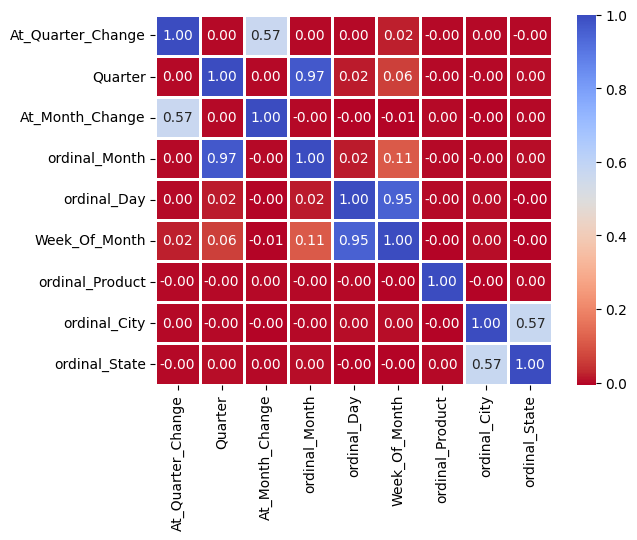

In [90]:
sns.heatmap(correlation, annot=True, linewidths=1, cmap='coolwarm_r', fmt="0.2f")

You would expect correlation between the features derived from `Order Date`, so this can be ignored. Similarly, features derived from the `Purchase Address` is expected to correlate, and can therefore be ignored as well.

However, the above heatmap also shows **no correlation between product, date, or location** -- which is atypical.

But as the products are electronic goods, it is reasonable to observe no seasonality or preference across locations. Sales spend may raise and fall over time, but not because a location or product is a driver.

In [91]:
#Drop features -- created in data elaboration -- that have no correlation, and are thus superfluous

df.drop([
    'At_Quarter_Change',
    'Quarter',
    'At_Month_Change',
    'ordinal_Day',
    'Day',
    'Week_Of_Month',
    'ordinal_Product',
    'ordinal_City',
    'ordinal_State'
    ], axis=1, inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 185950 entries, 73538 to 35323
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   Order ID          185950 non-null  int64         
 1   Product           185950 non-null  object        
 2   Quantity Ordered  185950 non-null  int64         
 3   Price Each        185950 non-null  float64       
 4   Order Date        185950 non-null  datetime64[ns]
 5   Line Total        185950 non-null  float64       
 6   ordinal_Month     185950 non-null  int32         
 7   Month             185950 non-null  object        
 8   City              185950 non-null  object        
 9   State             185950 non-null  object        
dtypes: datetime64[ns](1), float64(2), int32(1), int64(2), object(4)
memory usage: 14.9+ MB


### Total Spend and Volume by Month

In [92]:
total_spend_and_volume_by_month = df \
    .groupby(['Month', 'ordinal_Month']) \
    .agg({'Quantity Ordered': 'sum', 'Line Total': 'sum'}) \
    .sort_values(by='ordinal_Month')
    
total_spend_and_volume_by_month

,,Quantity Ordered,Line Total
Month,ordinal_Month,,
January,1,10903,1822256.73
February,2,13449,2202022.42
March,3,17005,2807100.38
April,4,20558,3390670.24
May,5,18667,3152606.75
June,6,15253,2577802.26
July,7,16072,2647775.76
August,8,13448,2244467.88
September,9,13109,2097560.13


### Total Spend and Volume by State and Product

In [93]:
total_spend_and_volume_by_state_and_product = df \
    .groupby(['State', 'Product']) \
    .agg({'Quantity Ordered': 'sum', 'Line Total': 'sum'}) \
    .sort_values(by='Line Total', ascending=False)
    
total_spend_and_volume_by_state_and_product

Quantity Ordered  Line Total
State Product                                               
CA    Macbook Pro Laptop                    1887  3207900.00
      iPhone                                2779  1945300.00
      ThinkPad Laptop                       1604  1603983.96
      Google Phone                          2206  1323600.00
NY    Macbook Pro Laptop                     657  1116900.00
...                                          ...         ...
ME    Lightning Charging Cable               269     4021.55
      LG Dryer                                 6     3600.00
      Wired Headphones                       279     3345.21
      AA Batteries (4-pack)                  389     1493.76
      AAA Batteries (4-pack)                 358     1070.42

[152 rows x 2 columns]

### Total Spend and Volume by Product

In [94]:
total_spend_and_volume_by_product = df \
    .groupby('Product') \
    .agg({'Quantity Ordered': 'sum', 'Line Total': 'sum'}) \
    .sort_values(by='Line Total', ascending=False)

total_spend_and_volume_by_product

,Quantity Ordered,Line Total
Product,,
Macbook Pro Laptop,4728,8037600.00
iPhone,6849,4794300.00
ThinkPad Laptop,4130,4129958.70
Google Phone,5532,3319200.00
27in 4K Gaming Monitor,6244,2435097.56
34in Ultrawide Monitor,6199,2355558.01
Apple Airpods Headphones,15661,2349150.00
Flatscreen TV,4819,1445700.00
Bose SoundSport Headphones,13457,1345565.43


### Top Products

In [95]:
top_products = total_spend_and_volume_by_product[:8]

top_products_spend_and_volume = pd.DataFrame(
    total_spend_and_volume_by_product.sum(), 
    columns=['Total'])

top_products_spend_and_volume['Top 5'] = top_products.sum()
top_products_spend_and_volume['Ratio'] = top_products_spend_and_volume['Top 5'] / top_products_spend_and_volume['Total']
top_products_spend_and_volume['Rest'] = 1 - top_products_spend_and_volume['Ratio']

top_products_spend_and_volume

,Total,Top 5,Ratio,Rest
Quantity Ordered,209079.00,54162.00,0.259050,0.740950
Line Total,34492035.97,28866564.27,0.836905,0.163095


### Top Products Total Spend and Volume by Month

In [96]:
top_products_total_spend_and_volume_by_month = df[df['Product'].isin( list(top_products.index) )] \
    .groupby(['Month', 'ordinal_Month', 'Product']) \
    .agg({'Quantity Ordered': 'sum', 'Line Total': 'sum'}) \
    .sort_values(by=['ordinal_Month', 'Line Total'], ascending=[True, False])

top_products_total_spend_and_volume_by_month


Quantity Ordered  Line Total
Month    ordinal_Month Product                                               
January  1             Macbook Pro Laptop                     235   399500.00
                       iPhone                                 381   266700.00
                       ThinkPad Laptop                        219   218997.81
                       Google Phone                           319   191400.00
                       Apple Airpods Headphones               818   122700.00
...                                                           ...         ...
December 12            Google Phone                           715   429000.00
                       27in 4K Gaming Monitor                 864   336951.36
                       34in Ultrawide Monitor                 849   322611.51
                       Apple Airpods Headphones              2076   311400.00
                       Flatscreen TV                          666   199800.00

[96 rows x 2 columns]

### Total Spend and Volume by Order

In [97]:
total_spend_and_volume_by_order = df \
    .groupby('Order ID') \
    .agg({'Quantity Ordered': 'sum', 'Line Total': 'sum'}) \
    .sort_values(by='Line Total', ascending=False)
    
total_spend_and_volume_by_order.describe()

,Quantity Ordered,Line Total
count,178437.000000,178437.000000
mean,1.171724,193.300918
std,0.501673,341.274261
min,1.000000,2.990000
25%,1.000000,11.950000
50%,1.000000,14.950000
75%,1.000000,150.000000
max,9.000000,3779.990000


### Orders with Top Products

In [137]:
lines_with_top_products = df[df['Product'].isin( list(top_products.index) )]

df['Top Product Order'] = df['Order ID'] \
    .isin( list(lines_with_top_products['Order ID'].unique()) )

orders_with_top_products = df.groupby('Top Product Order') \
    .agg({'Quantity Ordered': 'sum', 'Line Total': 'sum'}) \
    .sort_values(by='Line Total', ascending=False)
    
orders_with_top_products.set_index([pd.Index(['Top','Other'])], inplace=True)
orders_with_top_products = orders_with_top_products.T

orders_with_top_products['Total'] = orders_with_top_products['Top'] + orders_with_top_products['Other']
orders_with_top_products['Ratio'] = orders_with_top_products['Top'] / orders_with_top_products['Total']
orders_with_top_products['Rest'] = 1 - orders_with_top_products['Ratio']

orders_with_top_products

,Top,Other,Total,Ratio,Rest
Quantity Ordered,59184.00,149895.00,209079.00,0.283070,0.716930
Line Total,28993747.74,5498288.23,34492035.97,0.840593,0.159407


## Analysis

### Best month for Sales by Spend

### Best product for Sales by Spend

### Top products for >= 80% Sales by Spend